In [5]:
import os
#import _pickle as cPickle
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import regularizers
#from data_utils.py import load_CIFAR10
from keras.utils import to_categorical
params = {}
params['batch_size'] = 100
params['num_epochs'] = 100
params['learning_rate'] = 1e-2
params['activation'] = 'relu'
params['optimizer'] = 'sgd'
params['layers'] = [5, 2, 3, 4]
params['output_dim'] = 10
params['input_dim'] = 32*32*3
params['lr_decay'] = 0.5

In [2]:
def loadData():
    
    num_classes = 10

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    
    Y_train = keras.utils.to_categorical(Y_train, num_classes)
    Y_test = keras.utils.to_categorical(Y_test, num_classes)
    
    num_rows = X_train.shape[1]
    num_cols = X_train.shape[2]
    num_channels = X_train.shape[3]
    input_dims = num_rows*num_cols*num_channels 
    print(X_train.shape)
    
    #X_train = X_train.reshape(X_train.shape[0], input_dims)
    #X_test = X_test.reshape(X_test.shape[0], input_dims)
    
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
                          
    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = loadData()
print(X_train.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)


In [10]:
print("mean before normalization:", np.mean(X_train))
print("std before normalization:", np.std(X_train))

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)
for i in range(3):
    mean[i] = np.mean(X_train[:,i,:,:])
    std[i] = np.std(X_train[:,i,:,:])
    
for i in range(3):
    newX_train[:,i,:,:] = X_train[:,i,:,:] - mean[i]
    newX_train[:,i,:,:] = newX_train[:,i,:,:] / std[i]
    newX_test[:,i,:,:] = X_test[:,i,:,:] - mean[i]
    newX_test[:,i,:,:] = newX_test[:,i,:,:] / std[i]
        
    
X_train = newX_train
X_test = newX_test

print("mean after normalization:", np.mean(X_train))
print("std after normalization:", np.std(X_train))

mean before normalization: 0.473365
std before normalization: 0.251569
mean after normalization: 0.906249959712
std after normalization: 0.422742250199


In [13]:
num_classes = 10
data_mean = np.mean(X_train)
data_std_dev = np.std(X_train)
print(data_mean, data_std_dev)
print(X_train[0][0][0])

0.906249959712 0.422742250199
[-1.03643106 -0.99577655 -0.98222504]


In [12]:
def build_model(drop = False, wt_decay = 0.0, percent_noise = 0.0, noise_hidden = 0.0):
    model = Sequential()
    noise = (1.0/255) * percent_noise
    noise_hidden = (1.0/255) * noise_hidden
    model.add(GaussianNoise(noise, input_shape=(32, 32, 3)))
    model.add(Cropping2D(cropping=((2,2)), input_shape=(32,32,3) ))
    model.add(Convolution2D(200, 5, 5,                                    #-- 200 outputs (200 filters), 5x5 convolution kernel
                            border_mode='valid', kernel_regularizer=regularizers.l2(wt_decay)))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu')) 
    if drop == True:
        model.add(Dropout(0.1))
    model.add(GaussianNoise(noise_hidden))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Convolution2D(200,5,5, kernel_regularizer=regularizers.l2(wt_decay)))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu')) 
    if drop == True:
        model.add(Dropout(0.1))
    model.add(GaussianNoise(noise_hidden))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten()) 
    model.add(Dense(384, kernel_regularizer=regularizers.l2(wt_decay)))
    model.add(BatchNormalization(momentum=0.9))              #-- 120 outputs fully connected layer
    model.add(Activation('relu'))                                       #-- ReLU non-linearity 
    if drop == True:
        model.add(Dropout(0.1))
    model.add(GaussianNoise(noise_hidden))
    model.add(Dense(192, kernel_regularizer=regularizers.l2(wt_decay)))    #-- 84 outputs fully connected layer
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))                                       #-- ReLU non-linearity 
    if drop == True:
        model.add(Dropout(0.1))
    model.add(GaussianNoise(noise_hidden))
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(wt_decay)))     #-- 10 outputs fully connected layer (one for each class)
    model.add(Activation('softmax'))
    return model

## randY

In [7]:
np.random.seed(12345)
corrupt_prob = 1.0
labels = np.argmax(Y_train,1)
mask = np.random.rand(len(labels)) <= corrupt_prob
rnd_labels = np.random.choice(num_classes, mask.sum())
labels[mask] = rnd_labels
# we need to explicitly cast the labels from npy.int64 to
# builtin int type, otherwise pytorch will fail...
randY = [int(x) for x in labels]
randY = to_categorical(randY)

## Training with regularizers

### No regularization

In [8]:
sgd = SGD(lr=params['learning_rate'], decay=params['lr_decay'])
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x = X_train, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_1 = model.fit(x = X_train, y = randY, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
lis_noReg = history.history['acc']
lis_noReg_random = history_1.history['acc']

/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5), padding="valid", kernel_regularizer=<keras.reg...)`
  
/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(200, (5, 5), kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app


Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[100,200,24,24] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](cropping2d_1/strided_slice, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/add_4/_231 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1828_loss/add_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'conv2d_1/convolution', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/manisha.padala/env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-492533577a72>", line 2, in <module>
    model = build_model()
  File "<ipython-input-6-eb081b5fe0bb>", line 8, in build_model
    border_mode='valid', kernel_regularizer=regularizers.l2(wt_decay)))
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 781, in convolution
    return op(input, filter)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 869, in __call__
    return self.conv_op(inp, filter)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 521, in __call__
    return self.call(inp, filter)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 205, in __call__
    name=self.name)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/manisha.padala/env/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,200,24,24] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](cropping2d_1/strided_slice, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/add_4/_231 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1828_loss/add_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



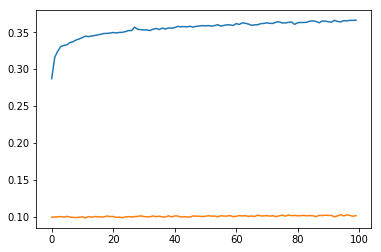

### Dropout

In [ ]:
sgd = SGD(lr=params['learning_rate'], decay=params['lr_decay'])
model = build_model(drop = True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x = X_train, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_1 = model.fit(x = X_train, y = randY, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
lis_Drop = history.history['acc']
lis_Drop_random = history_1.history['acc']

### Weight Decay : 0.001

In [2]:
sgd = SGD(lr=params['learning_rate'], decay=params['lr_decay'])
model = build_model(wt_decay = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x = X_train, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_1 = model.fit(x = X_train, y = randY, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
lis_WtDecay = history.history['acc']
lis_WtDecay_random = history_1.history['acc']

NameError: name 'build_model' is not defined

### Input Gaussian Noise 0.1

In [3]:
sgd = SGD(lr=params['learning_rate'], decay=params['lr_decay'])
model = build_model(percent_noise = 0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x = X_train, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_1 = model.fit(x = X_train, y = randY, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
lis_InpNoise = history.history['acc']
lis_InpNoise_random = history_1.history['acc']

NameError: name 'build_model' is not defined

### Hidden Gaussian 0.1

In [ ]:
sgd = SGD(lr=params['learning_rate'], decay=params['lr_decay'])
model = build_model(noise_hidden = 0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x = X_train, y = Y_train, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history_1 = model.fit(x = X_train, y = randY, verbose=2, batch_size=params['batch_size'], epochs=params['num_epochs'])
lis_HidNoise = history.history['acc']
lis_HidNoise_random = history_1.history['acc']

In [1]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.plot(lis_noReg)
ax1.plot(lis_Drop)
ax1.plot(lis_WtDecay)
ax1.plot(lis_InpNoise)
ax1.plot(lis_HidNoise)
ax2.plot(lis_noReg_random)
ax2.plot(lis_Drop_random)
ax2.plot(lis_WtDecay_random)
ax2.plot(lis_InpNoise_random)
ax2.plot(lis_HidNoise_random)
ax1.set_ylabel('Training Acc')
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Training Acc')
ax2.set_xlabel('Epoch')

plt.savefig('Reglarization.png')
plt.show()

NameError: name 'plt' is not defined